In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import cv

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/Users/amritambe/Desktop/Analysis_Project/Women_Empowerment/2 Data/Clean_Data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/Users/amritambe/Desktop/Analysis_Project/Women_Empowerment/2 Data/Clean_Data/GDP_Cleaned.csv
/Users/amritambe/Desktop/Analysis_Project/Women_Empowerment/2 Data/Clean_Data/.DS_Store
/Users/amritambe/Desktop/Analysis_Project/Women_Empowerment/2 Data/Clean_Data/WE_Index_Clean.csv
/Users/amritambe/Desktop/Analysis_Project/Women_Empowerment/2 Data/Clean_Data/11_13_2023_WEI.csv
/Users/amritambe/Desktop/Analysis_Project/Women_Empowerment/2 Data/Clean_Data/Child_Leave_Qs_Clean.csv
/Users/amritambe/Desktop/Analysis_Project/Women_Empowerment/2 Data/Clean_Data/Fifty_Year_Change_Clean.csv
/Users/amritambe/Desktop/Analysis_Project/Women_Empowerment/2 Data/Clean_Data/GDP_Clean.csv
/Users/amritambe/Desktop/Analysis_Project/Women_Empowerment/2 Data/Clean_Data/All_Questions_Clean.csv
/Users/amritambe/Desktop/Analysis_Project/Women_Empowerment/2 Data/Clean_Data/11_10_2023_WEI.csv


# Clean and Wrangle Data

In [2]:
#read in data
df = pd.read_csv('/Users/amritambe/Desktop/Analysis_Project/Women_Empowerment/2 Data/Clean_Data/11_13_2023_WEI.csv')
df = df.drop(columns='Unnamed: 0', axis=1)
#sort and fill na using 'ffill' (forward fill), and 'bfill' (backward fill)
df.sort_values(by=['Country_Name', 'Year'], ascending=True, inplace=True)
df[['Life_Exp', 'Population', 'GDP_Per_Cap']] = df[['Life_Exp', 'Population', 'GDP_Per_Cap']].fillna(method='ffill')
df[['Life_Exp', 'Population', 'GDP_Per_Cap']] = df[['Life_Exp', 'Population', 'GDP_Per_Cap']].fillna(method='bfill')
#fill mobile data price data
df[['2020_Data_Rank', '2020_1GB_Price(USD)']] = df[['2020_Data_Rank', '2020_1GB_Price(USD)']].fillna(method='ffill')
df[['2020_Data_Rank', '2020_1GB_Price(USD)']] = df[['2020_Data_Rank', '2020_1GB_Price(USD)']].fillna(method='bfill')
#impute 0 to GDP_Growth
df['GDP_Growth'].fillna(0, inplace=True)
df.isna().sum()
#export df
# df.to_csv('/Users/amritambe/Desktop/11_18_2023_WEI_CleanImputed.csv')


Country_Name           0
Year                   0
GDP_Growth             0
Index_1971             0
Index_2020             0
Fifty_Year_Change      0
Region                 0
Income_Group           0
Question_Category      0
Question               0
Index_Score            0
2020_Data_Rank         0
2020_1GB_Price(USD)    0
Life_Exp               0
Population             0
GDP_Per_Cap            0
Avg_WEI_Score          0
dtype: int64

# EDA
- All the life_exp, pop, gdppercap column nulls are from afghanistan in 1971
- Fill nulls with 1972 data 
    - df.query('Country_Name == "Afghanistan" and Year == 1972').head(35)
- (Life_Exp: 36.088	Population: 13079460.0	 GDP_Per_Cap: 739.981106)

In [3]:
#perform initial Exploratory Data Analysis with seaborn pairplot. ID any interesting variables
#sns.pairplot(df)

                        mean       min        max     median
Question_Category                                           
Assets             13.511053  5.048571  20.491429  13.842857
Entrepreneurship   13.511053  5.048571  20.491429  13.842857
Marriage           13.511053  5.048571  20.491429  13.842857
Mobility           13.511053  5.048571  20.491429  13.842857
Parenthood         13.511053  5.048571  20.491429  13.842857
Pay                13.511053  5.048571  20.491429  13.842857
Pension            13.511053  5.048571  20.491429  13.842857
Workplace          13.511053  5.048571  20.491429  13.842857


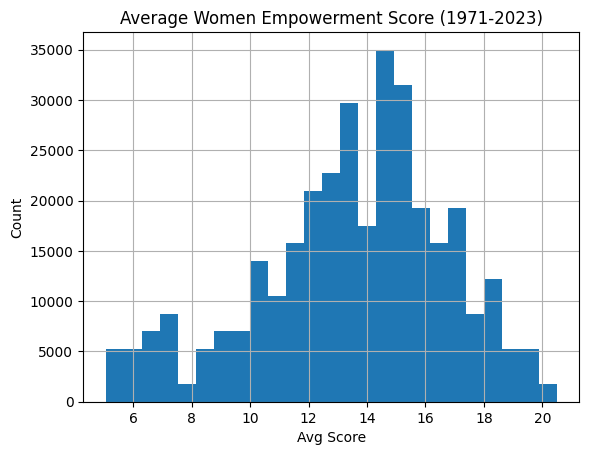

In [4]:
#analyze the average Women Empowerment Index scores
wei_score_stats = df.groupby('Question_Category')['Avg_WEI_Score'].agg(['mean', 'min', 'max', 'median'])
df['Avg_WEI_Score'].hist(bins=25)
plt.title('Average Women Empowerment Score (1971-2023)')
plt.xlabel('Avg Score')
plt.ylabel('Count')
avg_score_hist = plt.gca()
print(wei_score_stats)

# AVG_WEI_Score and Life_Exp
- There seems to be a slight positive correlation between AVG_WEI_Score, and the Life_Exp of the countries.
- Avg scores are between 0-20 latitude, with Higher values indicating more Northern houses
- Any statistical significance should be cognizant of a low sample size

The coefficient is:           0.1087
The RMSE is:                  9.2479
The R2 score is:              0.1520


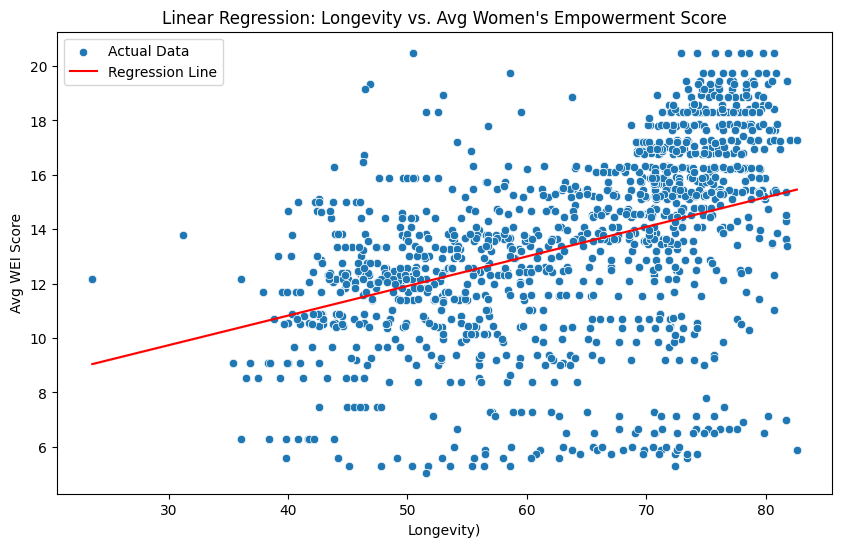

In [5]:
#Regression for distance from metro and price per unit
X = df['Life_Exp'].values.reshape(-1, 1)
y = df['Avg_WEI_Score'].values.reshape(-1, 1)

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#create Regression model object
regression = LinearRegression()

#fit the model
regression.fit(X_train, y_train)

#prediction measuring
y_pred = regression.predict(X_test)
#check the model
coef = regression.coef_.flatten()[0]
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'The coefficient is:  {coef:>15.4f}\nThe RMSE is:  {rmse:>22.4f}\nThe R2 score is:  {r2:>18.4f}')

# Assuming X_test and y_test are your test data and predictions
data = pd.DataFrame({'X_test': X_test.flatten(), 'y_test': y_test.flatten(), 'y_pred': y_pred.flatten()})

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='X_test', y='y_test', data=data, label='Actual Data')

# Regression line
sns.lineplot(x='X_test', y='y_pred', data=data, color='red', label='Regression Line')

plt.title("Linear Regression: Longevity vs. Avg Women's Empowerment Score")
plt.xlabel('Longevity)')
plt.ylabel('Avg WEI Score')
plt.legend()
plt.show()


In [6]:
compare = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
compare.sample(10)

,Actual,Predicted
10169,13.017143,12.361794
36753,14.320000,14.914826
35701,6.288571,11.243715
32571,12.594286,12.280782
25775,15.465714,13.742050
50746,12.925714,12.614836
2424,14.671429,11.206634
47561,10.900000,11.517308
22592,5.891429,15.460164
32028,16.811429,14.009227


In [7]:
print(f'The coefficient is:  {coef:>15.4f}\nThe RMSE is:  {rmse:>22.4f}\nThe R2 score is:  {r2:>18.4f}')


The coefficient is:           0.1087
The RMSE is:                  9.2479
The R2 score is:              0.1520


# Overall, the Life Expectancy affects the Women Empowerment Index minimally
- There may be a relationship, but the coefficient is very low indicating a small slope of the regression line
- The relationship is weak, though the mse is fairly low, there is a very low r2 score
- a univariate analysis is likely incomplete, as there are many variables to consider 

# We should now attempt to reverse the regression, and solve for WEI score using longevity


The coefficient is:           1.4211
The RMSE is:                119.5407
The R2 score is:              0.1521


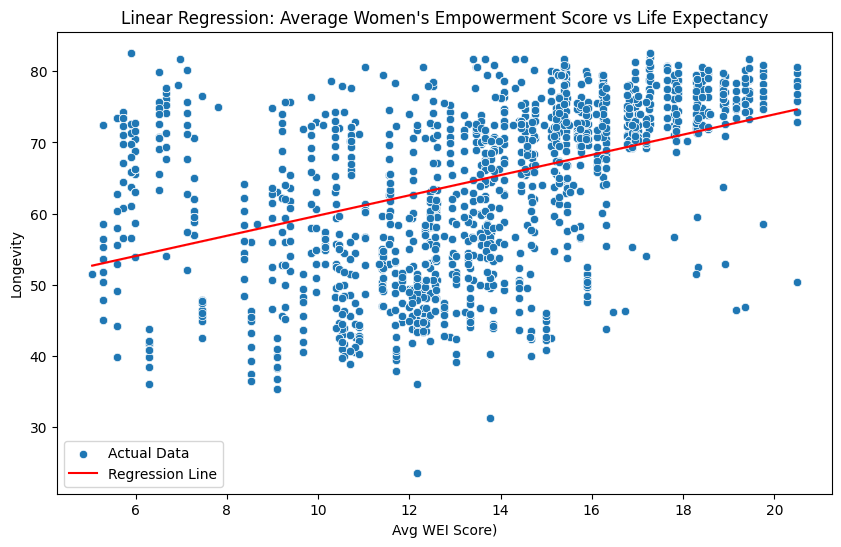

In [8]:
#Regression for distance from metro and price per unit
X = df['Avg_WEI_Score'].values.reshape(-1, 1)
y = df['Life_Exp'].values.reshape(-1, 1)

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#create Regression model object
regression = LinearRegression()

#fit the model
regression.fit(X_train, y_train)

#prediction measuring
y_pred = regression.predict(X_test)
#check the model
coef = regression.coef_.flatten()[0]
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'The coefficient is:  {coef:>15.4f}\nThe RMSE is:  {rmse:>22.4f}\nThe R2 score is:  {r2:>18.4f}')

# Assuming X_test and y_test are your test data and predictions
data = pd.DataFrame({'X_test': X_test.flatten(), 'y_test': y_test.flatten(), 'y_pred': y_pred.flatten()})

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='X_test', y='y_test', data=data, label='Actual Data')

# Regression line
sns.lineplot(x='X_test', y='y_pred', data=data, color='red', label='Regression Line')

plt.title("Linear Regression: Average Women's Empowerment Score vs Life Expectancy")
plt.xlabel('Avg WEI Score)')
plt.ylabel('Longevity')
plt.legend()
plt.show()


# Still a weak relationship
- the higher mse and persistent low r2 score indicates the model is not reliable


  
# # Therefore, lets train a multivariate model to predict Avg WEI Score  
- We can use a popular decision tree that uses gradient boosting by iterating and learning from it's mistakes
    - XGBoost
- for model interpretation, we can use values that indicate variable importance to the model, and which values of that variable are most important (high or low)
    - Shapely values

In [9]:
df.dtypes

Country_Name            object
Year                     int64
GDP_Growth             float64
Index_1971             float64
Index_2020             float64
Fifty_Year_Change      float64
Region                  object
Income_Group            object
Question_Category       object
Question                object
Index_Score            float64
2020_Data_Rank         float64
2020_1GB_Price(USD)    float64
Life_Exp               float64
Population             float64
GDP_Per_Cap            float64
Avg_WEI_Score          float64
dtype: object

In [10]:
#import new libraries
import xgboost as xgb
print(xgb.__version__)
from xgboost import XGBRegressor
import shap


2.0.2


In [11]:

#define new variables, m for multi
Xm = df[['Year', 'GDP_Growth', 'Index_1971', 'Index_2020',
       'Fifty_Year_Change', 'Region', 'Income_Group', 'Question_Category',
       'Question', 'Index_Score', '2020_Data_Rank', '2020_1GB_Price(USD)',
       'Life_Exp', 'Population', 'GDP_Per_Cap']]
ym = df['Avg_WEI_Score']

#get dummies
Xm = pd.get_dummies(Xm, columns=['Region', 'Income_Group', 'Question_Category', 'Question']).copy()
               
#train test split
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(Xm, ym, test_size=.2, random_state=42)

#generate the model
model_multi = XGBRegressor()

#train model
model_multi.fit(X_train_m, y_train_m)

#generate predictions
y_pred_multi = model_multi.predict(X_test_m)


#Run checks on model: feature importance, MSE, R2
#feature importance(no coefficient for multivariatemodels like xgb)
feature_importance = model_multi.feature_importances_

#create data frame for feature importance and sort
df_feature_importance = pd.DataFrame({'Feature': X_train_m.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
df_feature_importance = df_feature_importance.sort_values(by='Importance', ascending=False)

#generate mse for predictions
mse_multi = mean_squared_error(y_test_m, y_pred_multi)

#calculate r2 score for predictions
r2_multi = r2_score(y_test_m, y_pred_multi)

print(f'Multivariate XGBoost model\n\
The RMSE is:  {mse_multi:>22.4f}\n\
The R2 score is:  {r2_multi:>18.4f}\n\n\
Feature Importance: {df_feature_importance.head(10)}')


Multivariate XGBoost model
The RMSE is:                  0.0000
The R2 score is:              1.0000

Feature Importance:                               Feature  Importance
3                          Index_2020    0.593159
2                          Index_1971    0.140667
13           Region_High income: OECD    0.064844
14   Region_Latin America & Caribbean    0.058331
18           Income_Group_High income    0.032363
20   Income_Group_Lower middle income    0.025550
15  Region_Middle East & North Africa    0.021967
17          Region_Sub-Saharan Africa    0.017002
6                      2020_Data_Rank    0.009520
4                   Fifty_Year_Change    0.008218


# Feature Importance
- the XGB library has feature importance built in, and ranks the features in importance
- This model has 100% accuracy and so is vastly OVERFIT, therefore we need to tweak some settings in order to make this reliable    
- Shapely values can go one step further and explain how features are predicting within the model

[22:24:09] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[22:24:10] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


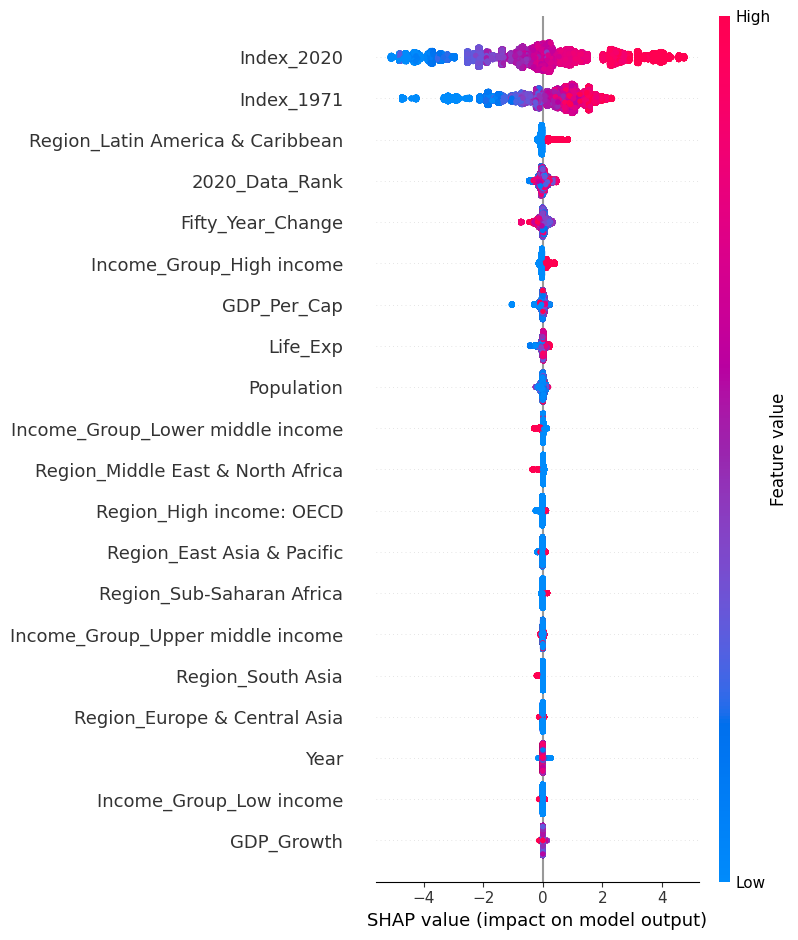

In [12]:
#Shapely Values can further explain feature importance

#generate explainer object
explainer = shap.Explainer(model_multi)

#calculate shap values
shap_values = explainer.shap_values(X_test_m)

#plot values
shap.summary_plot(shap_values, X_test_m)

# SHAP values
- this shows high feature values in red, low feature values in blue
- the further out from the 0 line, the more importance the feature is in the predictive model
- positive x axis values indicate higher WEI Score predictions, 
- negative x axis values indicate lower predictions

# lets reduce overfitting
- regularization (penalty term added to avoid overfitting)
- feature selection (taking away non-important, redundant, or correlated features)
- early stopping (setting a threshold of improvement below which training stops to avoid overfitting)

In [13]:
df.columns

Index(['Country_Name', 'Year', 'GDP_Growth', 'Index_1971', 'Index_2020',
       'Fifty_Year_Change', 'Region', 'Income_Group', 'Question_Category',
       'Question', 'Index_Score', '2020_Data_Rank', '2020_1GB_Price(USD)',
       'Life_Exp', 'Population', 'GDP_Per_Cap', 'Avg_WEI_Score'],
      dtype='object')

Multivariate XGBoost model
The RMSE is:                  2.2458
The R2 score is:              0.7929

                              Feature  Importance
15           Income_Group_High income    0.256851
12  Region_Middle East & North Africa    0.240396
14          Region_Sub-Saharan Africa    0.075375
10           Region_High income: OECD    0.057712
13                  Region_South Asia    0.053790
5                            Life_Exp    0.053034
11   Region_Latin America & Caribbean    0.046557
18   Income_Group_Upper middle income    0.042927
9        Region_Europe & Central Asia    0.042618
2                         Index_Score    0.024138


[11:22:18] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:22:19] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


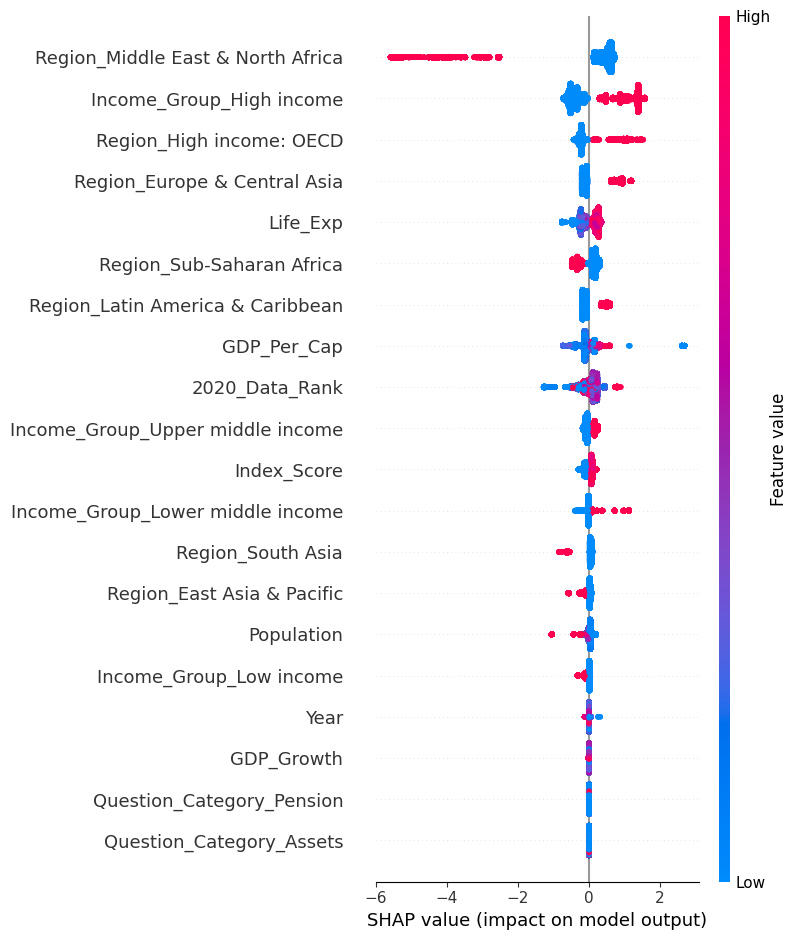

In [90]:
#Feature selection
#lets remove features that are overrepresented in importance:
Xm = df[['Year', 'GDP_Growth',
        'Region', 'Income_Group', 'Question_Category',
        'Index_Score', '2020_Data_Rank', '2020_1GB_Price(USD)',
       'Life_Exp', 'Population', 'GDP_Per_Cap']].copy()
ym = df['Avg_WEI_Score']

#get dummies
Xm = pd.get_dummies(Xm, columns=['Region', 'Income_Group', 'Question_Category']).copy()
               
#train test split
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(Xm, ym, test_size=.2, random_state=42)

#generate the model
model_multi = XGBRegressor(n_estimators=200,
                          max_depth=4,
                          eta=0.01,
                          eval_metric="rmse",  # Choose an appropriate evaluation metric
                          early_stopping_rounds=10  # Stop if no improvement on the evaluation set for 10 rounds
                          )

#create evaluation set, gives a target for early stopping
eval_set = [(X_train_m, y_train_m), (X_test_m, y_test_m)]
#train the model
model_multi.fit(
    X_train_m, y_train_m,
    eval_set=eval_set,
    verbose=False
)

#generate predictions
y_pred_multi = model_multi.predict(X_test_m)


#Run checks on model: feature importance, MSE, R2
#feature importance(no coefficient for multivariatemodels like xgb)
feature_importance = model_multi.feature_importances_

#create data frame for feature importance and sort
df_feature_importance = pd.DataFrame({'Feature': X_train_m.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
df_feature_importance = df_feature_importance.sort_values(by='Importance', ascending=False)

#generate mse for predictions
mse_multi = mean_squared_error(y_test_m, y_pred_multi)

#calculate r2 score for predictions
r2_multi = r2_score(y_test_m, y_pred_multi)

print(f'Multivariate XGBoost model\n\
The RMSE is:  {mse_multi:>22.4f}\n\
The R2 score is:  {r2_multi:>18.4f}\n\n\
{df_feature_importance.head(10)}')

#Shapely Values can further explain feature importance

#generate explainer object
explainer = shap.Explainer(model_multi)

#calculate shap values
shap_values = explainer.shap_values(X_test_m)

#plot values
shap.summary_plot(shap_values, X_test_m)

# Here we have avoided overfitting our model
- The main takeaway:
- # Regional and income differences are the most significant predictor of Women's Empowerment Index #
- having a region of the middle east/ north africa is the single greatest predictor of womens empowerment
   - The second and third most significant feature is the High income_group and high income region.
- SHAP values allow you to see the not only the feature importance, but the feature value importance.
  -  the further from 0 line, the more significant the feature value to the model

# # k-fold
we already have the variables Xm and y for training

Kfold in order to cross validate the model

Fold 1, MSE: 2.45703, R2: 0.77419
Fold 2, MSE: 2.49839, R2: 0.76930
Fold 3, MSE: 2.31965, R2: 0.78577
Fold 4, MSE: 2.49772, R2: 0.76886
Fold 5, MSE: 2.60471, R2: 0.76010


[16:23:45] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


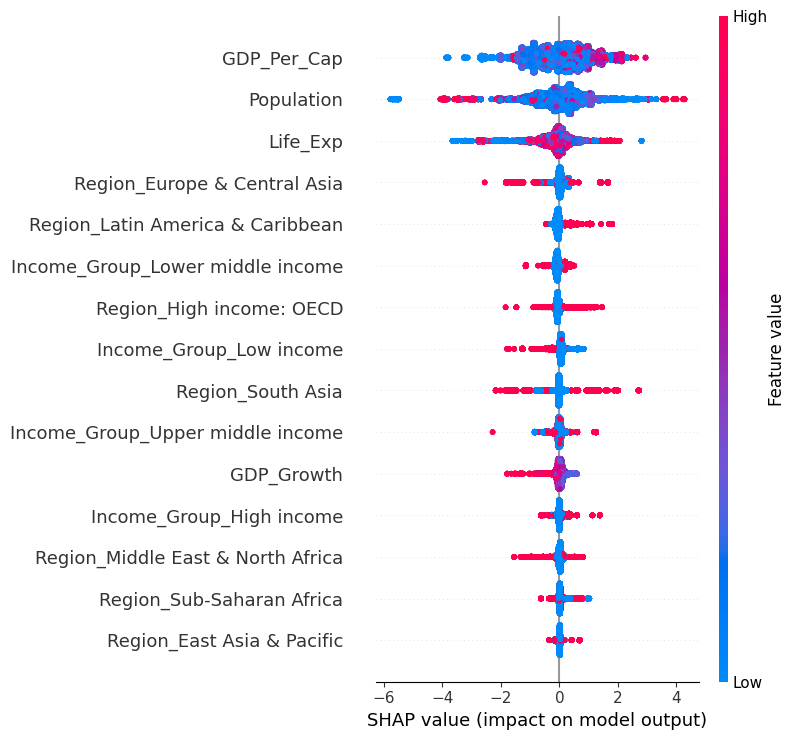

In [127]:
from sklearn import model_selection
from sklearn.model_selection import KFold

#feature selection
Xk = df[['GDP_Growth', 'Region', 'Income_Group',
       'Life_Exp', 'Population', 'GDP_Per_Cap']].copy()

yk = df['Avg_WEI_Score'].copy()

#get dummies
Xk = pd.get_dummies(Xk, columns=['Region', 'Income_Group'])

#generate xgboost model and initialize parameters
model_k = XGBRegressor(n_estimators=200, 
                      max_depth=4,
                      eta=0.1,
                      # alpha=1,
                      # subsample=1,
                      eval_metric='rmse',
                      early_stopping_rounds=10
                      ) 

#K Fold Validation
num_folds = 5

#create k fold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=59)

#generate splits, train models in for loop and print checks
for i, (train_idx, test_idx) in enumerate(kf.split(Xk)):
    # train_idx = np.array(train_idx)
    # test_idx = np.array(test_idx)
    X_train, X_test = Xk.iloc[train_idx,:], Xk.iloc[test_idx,:]
    y_train, y_test = yk[train_idx], yk[test_idx]

    eval_set = [(X_test, y_test)] #eval set for early stopping
    
    model_k.fit(X_train, y_train,
                eval_set=eval_set, #training model
                verbose=False)
    
    y_pred = model_k.predict(X_test) #create prediction

    mse = mean_squared_error(y_test, y_pred) #generate mse metric for each fold

    r2 = r2_score(y_test, y_pred) # calc r2

    #print check for each fold:
    print(f'Fold {i+1}, MSE: {mse:.5f}, R2: {r2:.5f}')
    
#Shap for the new model
explainer_k = shap.Explainer(model_k)
shap_values_k = explainer_k.shap_values(X_test)
shap.summary_plot(shap_values_k, X_test)

# using XGB methods:
- Dmatrix object for training fast
- .cv() method for internal cross validation

In [124]:
Xk.columns

Index(['GDP_Growth', 'Life_Exp', 'Population', 'GDP_Per_Cap',
       'Region_East Asia & Pacific', 'Region_Europe & Central Asia',
       'Region_High income: OECD', 'Region_Latin America & Caribbean',
       'Region_Middle East & North Africa', 'Region_South Asia',
       'Region_Sub-Saharan Africa', 'Income_Group_High income',
       'Income_Group_Low income', 'Income_Group_Lower middle income',
       'Income_Group_Upper middle income'],
      dtype='object')

[0]	train-rmse:3.05580+0.00084	test-rmse:3.05582+0.00390
[50]	train-rmse:1.25719+0.00700	test-rmse:1.25806+0.00650
[100]	train-rmse:1.04703+0.00637	test-rmse:1.04884+0.00927
[150]	train-rmse:0.90001+0.01584	test-rmse:0.90152+0.01524
[200]	train-rmse:0.79574+0.01434	test-rmse:0.79767+0.01183
[250]	train-rmse:0.71384+0.01291	test-rmse:0.71573+0.01082
[300]	train-rmse:0.64523+0.01537	test-rmse:0.64730+0.01633
[350]	train-rmse:0.59003+0.01092	test-rmse:0.59225+0.01288
[400]	train-rmse:0.54242+0.01019	test-rmse:0.54493+0.01205
[450]	train-rmse:0.50453+0.01028	test-rmse:0.50685+0.01172
[499]	train-rmse:0.47084+0.00988	test-rmse:0.47278+0.01096


[20:22:29] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[20:22:30] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


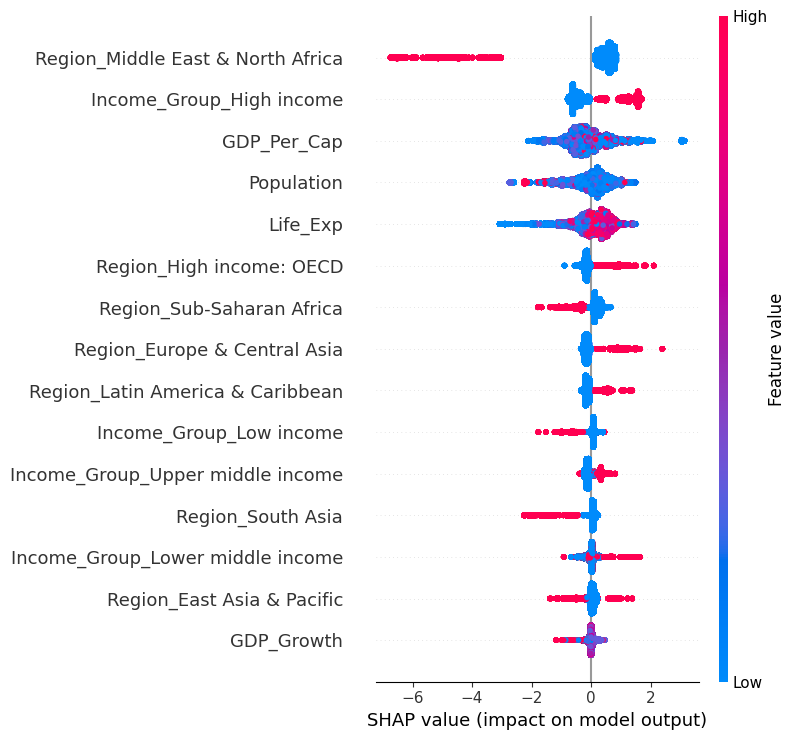

In [159]:
#import cv method from xgboost
from xgboost import cv

#define number of folds
nfolds = 5

#dmatrix is an object optimized for xgboost
dmatrix = xgb.DMatrix(Xk, yk)

#set parameters in a dictionary for the model
params = {
    'objective':'reg:squarederror',
            'max_depth': 4,
            'learning_rate': .1        
         }         

#execute cross validation
model_d = cv(dtrain=dmatrix, 
             params=params,
             nfold=nfolds, 
             num_boost_round=500, 
             early_stopping_rounds=10, 
             metrics='rmse',
             as_pandas=True, 
             seed=59,
             verbose_eval=50
            )

#find model with lowest rmse score
best_rounds = model_d['test-rmse-mean'].idxmin()


#train the model that produced lowest rmse
top_model = xgb.train(params, data_dmatrix, num_boost_round=best_rounds)

                      
#Shapely model interpretation
explainer_cv = shap.Explainer(top_model)
shap_values_d = explainer_cv.shap_values(Xk)
shap.summary_plot(shap_values_d, Xk)



In [160]:
best_rounds

499

In [161]:
from sklearn.metrics import mean_absolute_error

prediction = top_model.predict(xgb.DMatrix(Xk))     #generate predictions on entire dataset

mse_k = mean_squared_error(yk, prediction)          #calculate accuracy scores
r2_k = r2_score(yk, prediction)
mae_k = mean_absolute_error(yk, prediction)

print('Info for target: "Average WEI Index Score"\n',yk.agg(['min', 'max', 'median', 'mean', 'std']))
print(f'\n\nTesting on the entire dataset yields a:\n\
mse of {mse_k:>10.4f}\n r2 of {r2_k:>10.4f}\nmae of {mae_k:>10.4f}')

Info for target: "Average WEI Index Score"
 min        5.048571
max       20.491429
median    13.842857
mean      13.511053
std        3.292529
Name: Avg_WEI_Score, dtype: float64


Testing on the entire dataset yields a:
mse of     0.2250
 r2 of     0.9792
mae of     0.3081
